<a href="https://colab.research.google.com/github/aayushhks/twitter-sentiment-analysis/blob/main/test_dl_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:4.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.U70LRN_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.U70LRN_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [4]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
width, height = 224, 224
TRAIN_LENGTH = info.splits['train'].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [5]:
def normalize(input_image, input_mask):
    img = tf.cast(input_image, dtype=tf.float32) / 255.0
    input_mask -= 1
    return img, input_mask


@tf.function
def load_train_ds(example):
    img = tf.image.resize(example['image'], (width, height))
    mask = tf.image.resize(example['segmentation_mask'], (width, height))
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    img, mask = normalize(img, mask)
    return img, mask

In [6]:
train = dataset['train'].map(
    load_train_ds, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_train_ds)
train_ds = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test.batch(BATCH_SIZE)

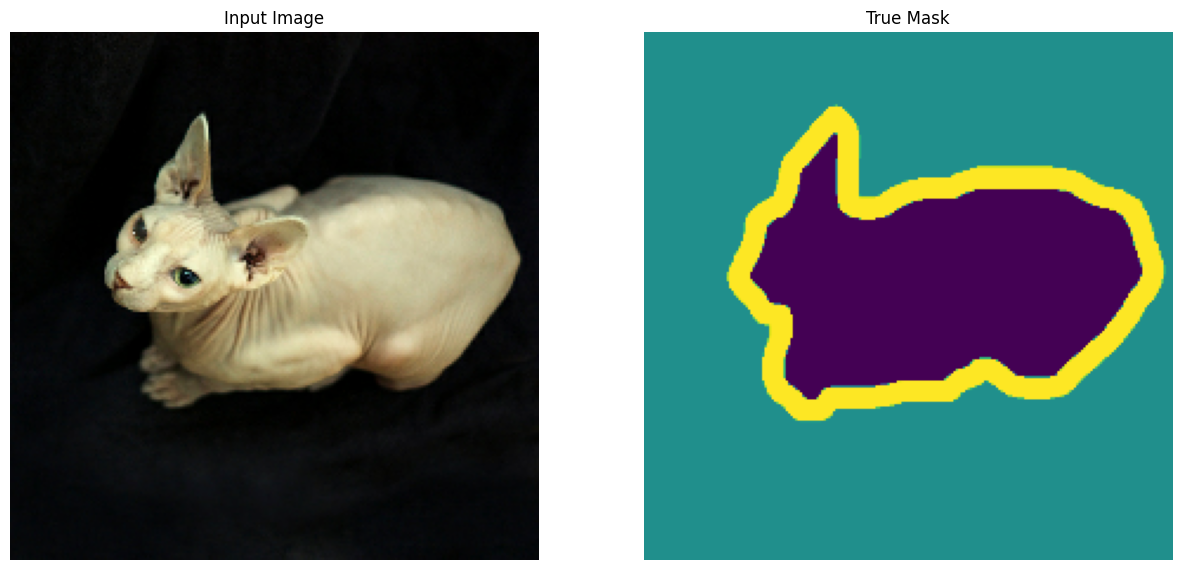

In [7]:
def display_images(display_list):
    plt.figure(figsize=(15, 15))
    titles = ['Input Image', 'True Mask', 'Predicted Mask']
    for i, image in enumerate(display_list):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(titles[i])
        plt.imshow(keras.preprocessing.image.array_to_img(image))
        plt.axis('off')
    plt.show()

for img, mask in train.take(1):
    display_images([img, mask])

In [8]:
base_model = keras.applications.vgg16.VGG16(
    include_top=False, input_shape=(width, height, 3))
layer_names = ['block1_pool', 'block2_pool',
               'block3_pool', 'block4_pool', 'block5_pool']
base_model_outputs = [base_model.get_layer(
    name).output for name in layer_names]
base_model.trainable = False
VGG_16 = keras.Model(inputs=base_model.input, outputs=base_model_outputs)


def fcn8_decoder(convs, n_classes):
    f1, f2, f3, f4, p5 = convs
    n = 4096
    c6 = keras.layers.Conv2D(n, (7, 7), activation='relu', padding='same')(p5)
    c7 = keras.layers.Conv2D(n, (1, 1), activation='relu', padding='same')(c6)
    f5 = c7
    o = keras.layers.Conv2DTranspose(
        n_classes, (4, 4), strides=(2, 2), use_bias=False)(f5)
    o = keras.layers.Cropping2D((1, 1))(o)
    o2 = keras.layers.Conv2D(
        n_classes, (1, 1), activation='relu', padding='same')(f4)
    o = keras.layers.Add()([o, o2])
    o = keras.layers.Conv2DTranspose(
        n_classes, (4, 4), strides=(2, 2), use_bias=False)(o)
    o = keras.layers.Cropping2D((1, 1))(o)
    o2 = keras.layers.Conv2D(
        n_classes, (1, 1), activation='relu', padding='same')(f3)
    o = keras.layers.Add()([o, o2])
    o = keras.layers.Conv2DTranspose(
        n_classes, (8, 8), strides=(8, 8), use_bias=False)(o)
    o = keras.layers.Activation('softmax')(o)
    return o

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [9]:
def segmentation_model():
    inputs = keras.layers.Input(shape=(width, height, 3))
    convs = VGG_16(inputs)
    outputs = fcn8_decoder(convs, 3)
    return keras.Model(inputs, outputs)


model = segmentation_model()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [10]:
EPOCHS = 15
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(
    train_ds, epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=test_ds,
    validation_steps=VALIDATION_STEPS
)

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


57/57 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.4132 - loss: 1.1344 - val_accuracy: 0.6885 - val_loss: 0.6806
Epoch 2/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 86s 865ms/step - accuracy: 0.7642 - loss: 0.5663 - val_accuracy: 0.8052 - val_loss: 0.4630
Epoch 3/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 49s 862ms/step - accuracy: 0.8212 - loss: 0.4274 - val_accuracy: 0.8193 - val_loss: 0.4294
Epoch 4/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 49s 859ms/step - accuracy: 0.8360 - loss: 0.3791 - val_accuracy: 0.8214 - val_loss: 0.4168
Epoch 5/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 49s 859ms/step - accuracy: 0.8419 - loss: 0.3583 - val_accuracy: 0.8254 - val_loss: 0.4179
Epoch 6/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 49s 861ms/step - accuracy: 0.8508 - loss: 0.3258 - val_accuracy: 0.8287 - val_loss: 0.4077
Epoch 7/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 49s 865ms/step - accuracy: 0.8579 - loss: 0.3052 - val_accuracy: 0.8323 - val_loss: 0.4210
Epoch 8/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 49s 862ms/step - accuracy: 0.8686 - loss: 0.2827 - val_accuracy: 0.8406 

In [16]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def show_predictions(dataset=None, num=1):
    for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        display_images([image[0], mask[0], create_mask(pred_mask)])

In [17]:
def compute_metrics(y_true, y_pred):
    class_wise_iou, class_wise_dice_score = [], []
    smooth = 1e-5
    for i in range(3):
        intersection = np.sum((y_pred == i) & (y_true == i))
        y_true_area = np.sum(y_true == i)
        y_pred_area = np.sum(y_pred == i)
        combined_area = y_true_area + y_pred_area
        iou = (intersection + smooth) / (combined_area - intersection + smooth)
        dice = 2 * (intersection + smooth) / (combined_area + smooth)
        class_wise_iou.append(iou)
        class_wise_dice_score.append(dice)
    return class_wise_iou, class_wise_dice_score